# 20220510-overlap
## Overlap matrices on each trace.

In [1]:
from collections import defaultdict
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from utils import utils

In [2]:
overlap_trace_dir = '/scratch/cluster/azheng/results/'
weight_path = '/scratch/cluster/cmolder/traces/spec06/champsim/weights.txt'
weights = utils.read_weights_file(weight_path)
dpi = None

In [3]:
os.makedirs('plots/overlap/per_trace/', exist_ok=True)
os.makedirs('plots/overlap/per_simpoint/', exist_ok=True)

# Helper functions

In [4]:
def build_overlap_matrix(path):
    key = {}
    single_idxs = []
    total = {}
    with open(path) as f:
        for line in f:# Get totals
            if 'Total Prefetches by' in line:
                tokens = line.split()
                index, name = int(tokens[3].replace(':', '')), tokens[4].replace('_:', '').replace('scooby', 'pythia')
                key[index] = name
                if ',' not in name:
                    single_idxs.append(index)
                
                total[name] = int(tokens[5])
        
        overlap = np.identity((len(total))) # Get overlap percents
        f.seek(0)
        for line in f:
            if 'Prefetches Shared by' in line:
                tokens = line.split()
                x1, x2 = int(tokens[3].replace('(', '').replace(':','')), int(tokens[5].replace(':',''))
                sum_total = (total[key[x1]] + total[key[x2]])
                overlap[x1, x2] = int(tokens[-1]) / sum_total if sum_total > 0 else 0#np.nan
                overlap[x2, x1] = overlap[x1, x2]
        
        np.set_printoptions(linewidth=1000)
        single_overlap = overlap[single_idxs, :][:, single_idxs]
        #print('DEBUG', single_overlap)
        #print('DEBUG', [key[i] for i in single_idxs])
        
        return single_overlap, [key[i] for i in single_idxs]

In [16]:
def plot_overlap_matrix(matrix, labels, dpi=None, title=None):
    
    # Used code from https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    fig, ax = plt.subplots(dpi=dpi)
    ax.imshow(matrix)
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels=labels)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            color = 'black' if matrix[i][j] > 0.5 else 'w'
            
            text = ax.text(j, i, round(matrix[i, j]*100., 1),
                          ha='center', va='center', color=color)
            
    
    fig.suptitle(title)
    fig.tight_layout()

# Collect overlap matrices (per-simpoint)

In [6]:
matrices = defaultdict(dict)
for path in glob.glob(os.path.join(overlap_trace_dir, '*.txt')):
    #if 'libquantum' in path: # DEBUG : Until sweep finishes
    #    break
    
    trace, simpoint  = os.path.basename(path).replace('.txt', '').split('_') # TODO: Work for GAP
    matrices[trace][simpoint], labels = build_overlap_matrix(path)

# Plot overlap matrices
## Across all traces, weighted by simpoint

In [7]:
def get_weighted_overlap_matrices(matrices):
    weighted_matrices = {}
    for trace in matrices:
        weighted_matrices[trace] = np.zeros((len(labels), len(labels)))
        tr_weights = weights[weights.trace == trace].copy()
        tr_weights['weight_norm'] = tr_weights.weight / tr_weights.weight.sum()
        for simpoint in matrices[trace]:
            weight = tr_weights[tr_weights.simpoint == simpoint].weight_norm.item()
            weighted_matrices[trace] += matrices[trace][simpoint]*weight
    
    return weighted_matrices

In [8]:
def get_overall_overlap_matrix(matrices):
    weighted_matrices = get_weighted_overlap_matrices(matrices)
    weight = 1 / len(weighted_matrices.keys())
    
    overall_matrix = np.zeros((len(labels), len(labels)))
    for trace in weighted_matrices:
        overall_matrix += weighted_matrices[trace] * weight
            
    return overall_matrix

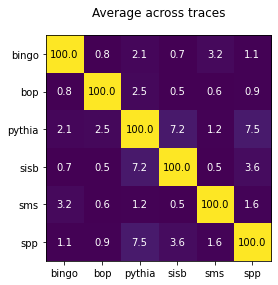

In [18]:
overall_matrix = get_overall_overlap_matrix(matrices)
plot_overlap_matrix(overall_matrix, labels, 
                    dpi=dpi, title='Average across traces')
plt.savefig(f'plots/overlap/overall.pdf')
plt.show()

## Per trace, weighted by simpoint

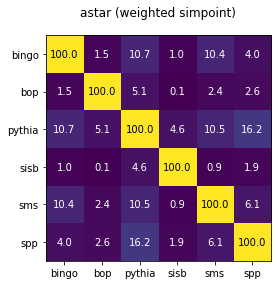

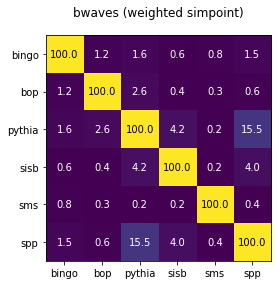

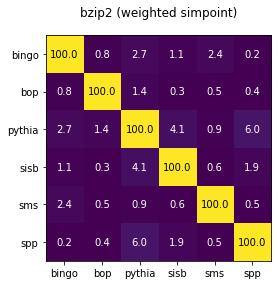

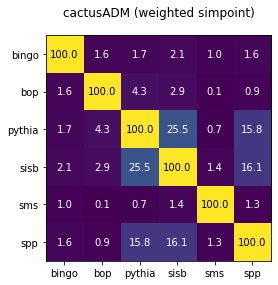

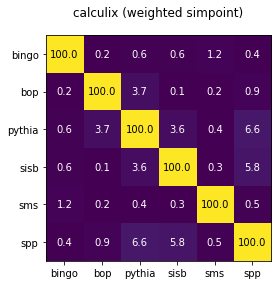

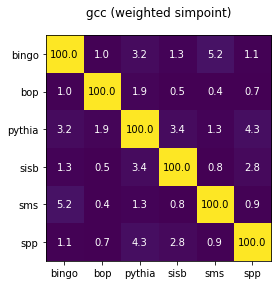

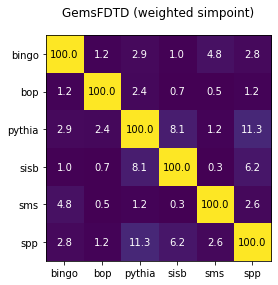

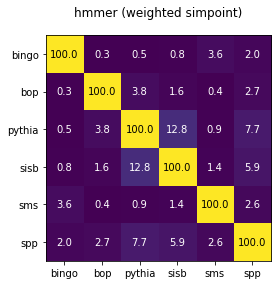

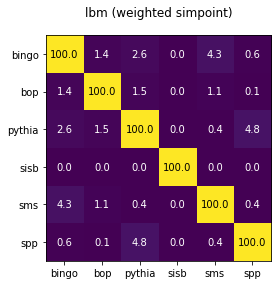

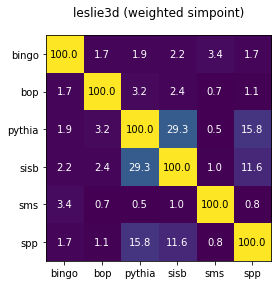

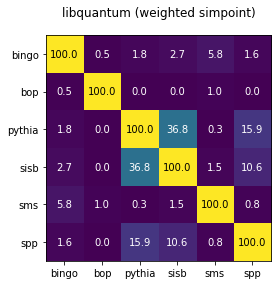

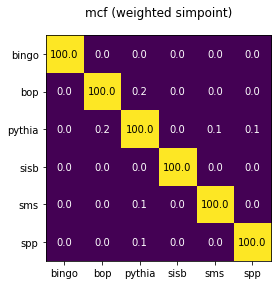

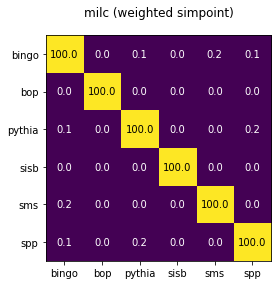

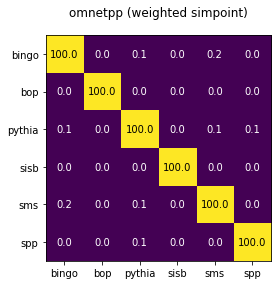

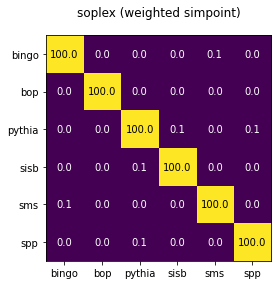

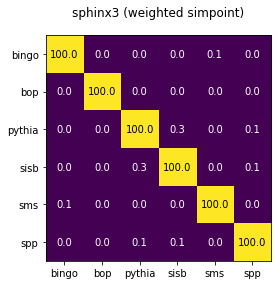

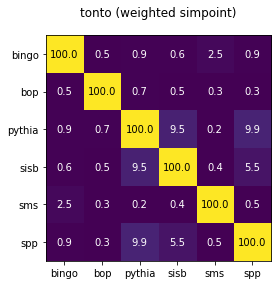

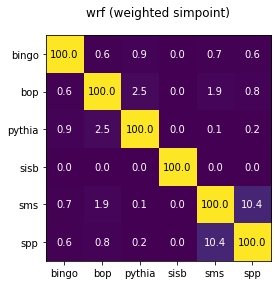

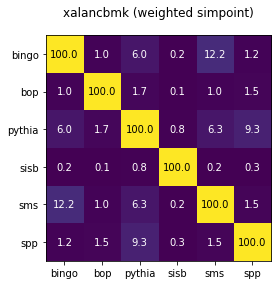

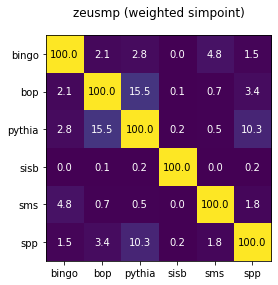

In [19]:
weighted_matrices = get_weighted_overlap_matrices(matrices)
for trace in weighted_matrices:
        plot_overlap_matrix(weighted_matrices[trace], labels, 
                            dpi=dpi, title=trace + ' (weighted simpoint)')
        plt.savefig(f'plots/overlap/per_trace/{trace}.pdf')
        plt.show()

## Per-simpoint

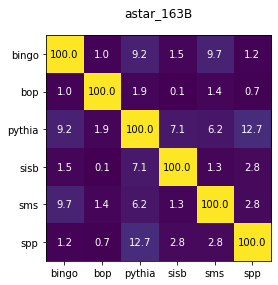

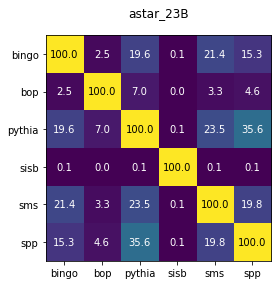

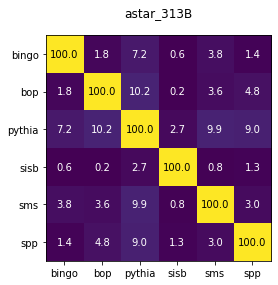

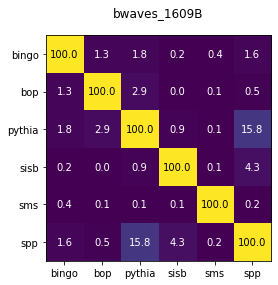

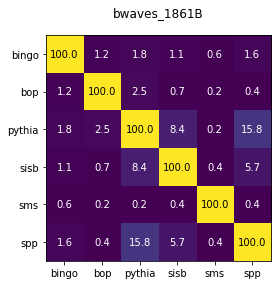

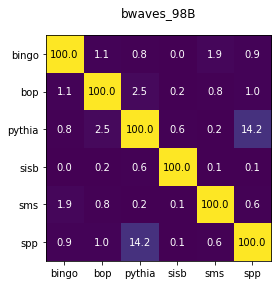

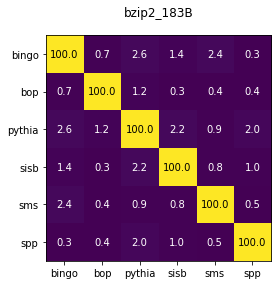

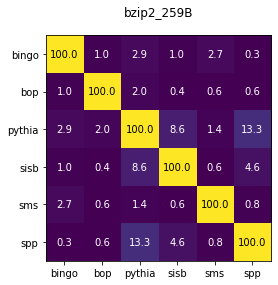

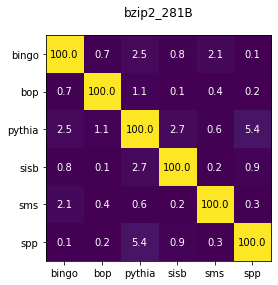

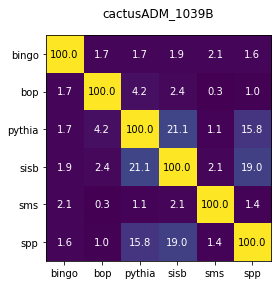

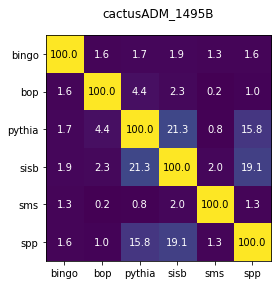

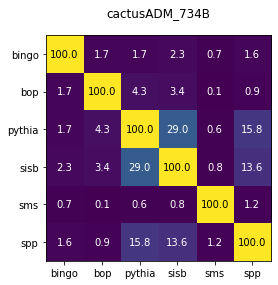

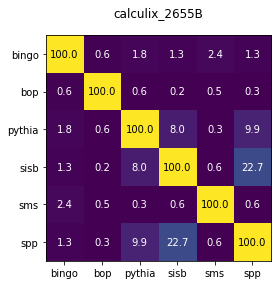

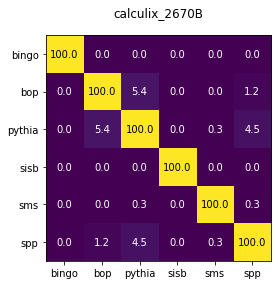

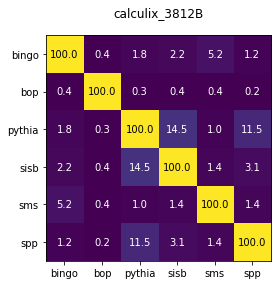

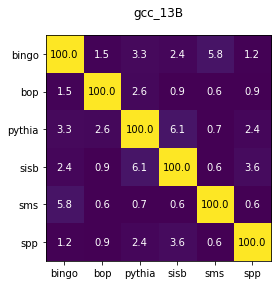

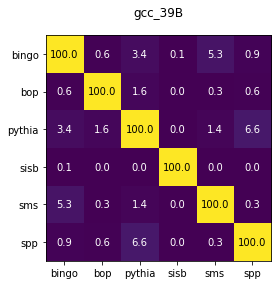

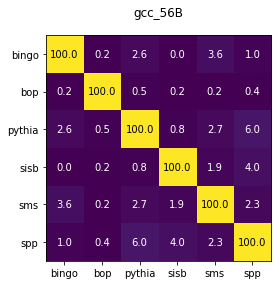

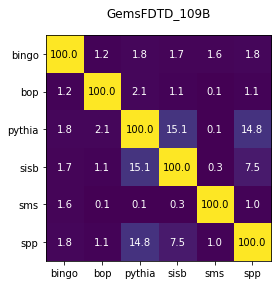

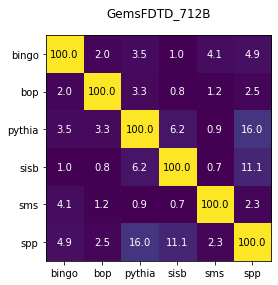

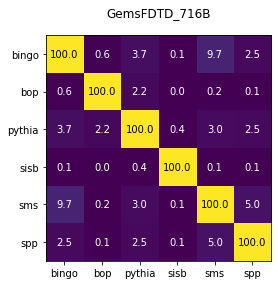

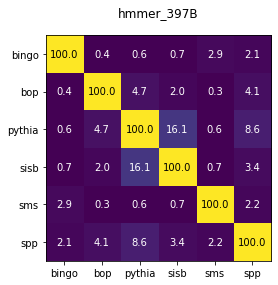

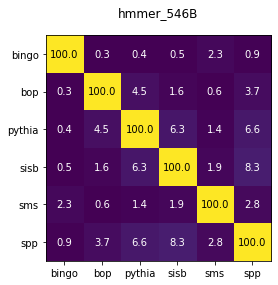

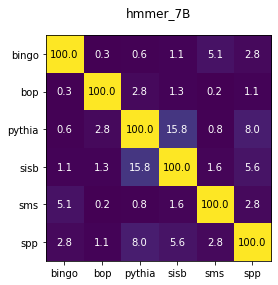

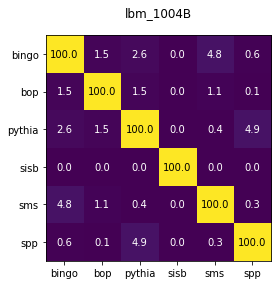

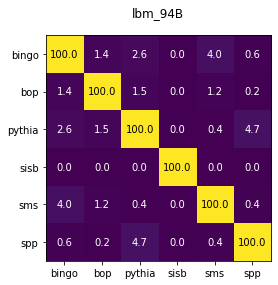

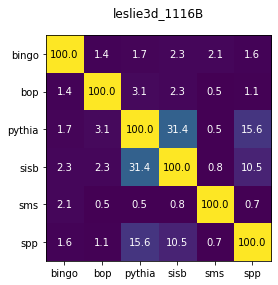

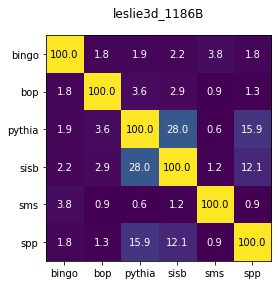

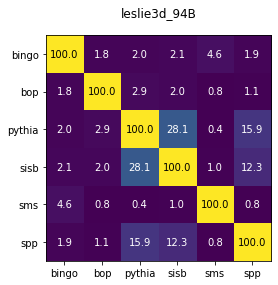

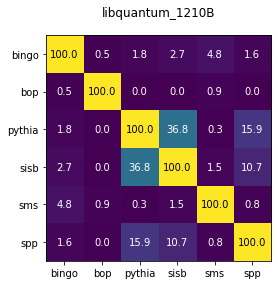

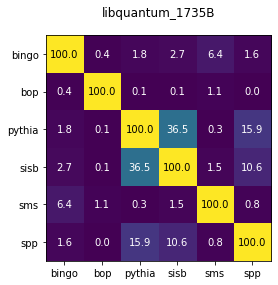

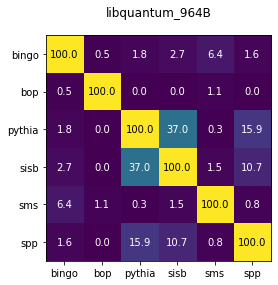

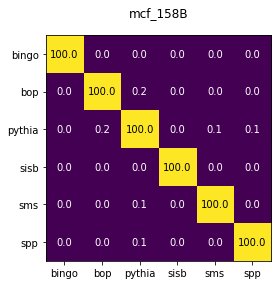

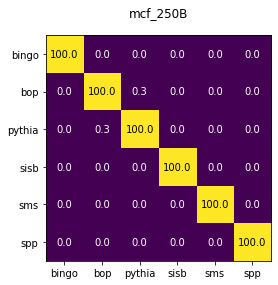

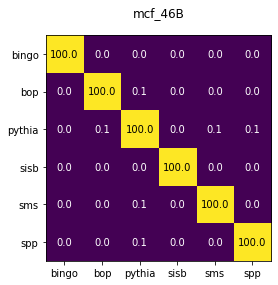

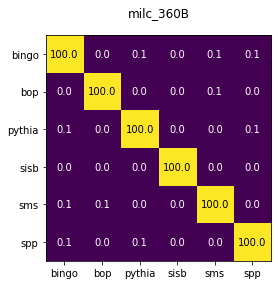

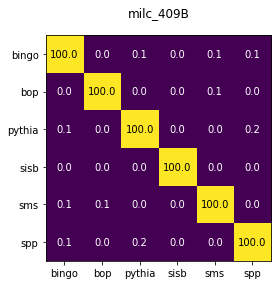

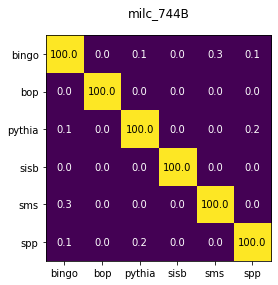

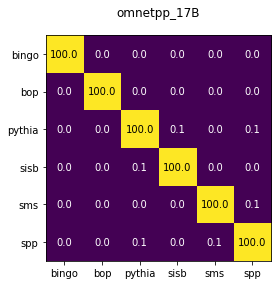

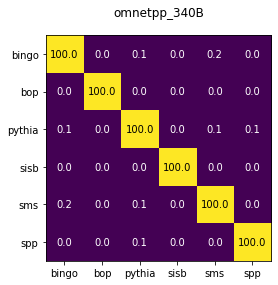

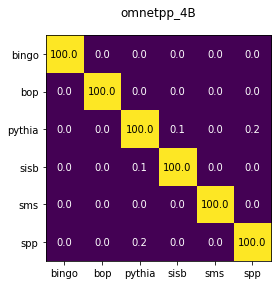

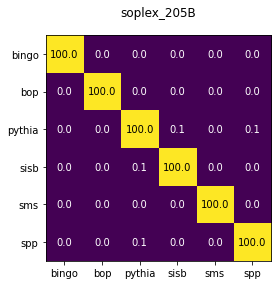

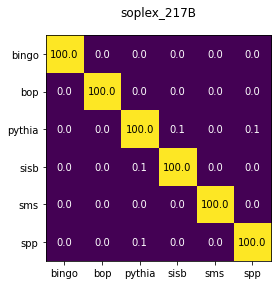

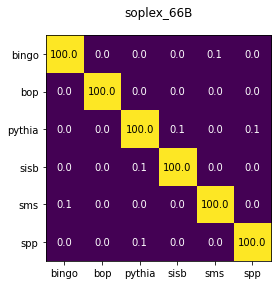

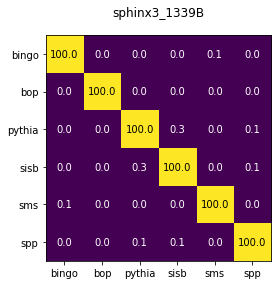

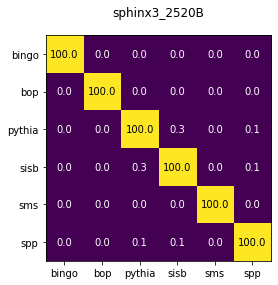

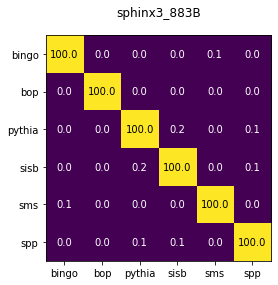

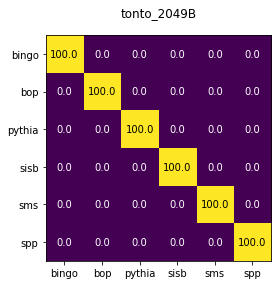

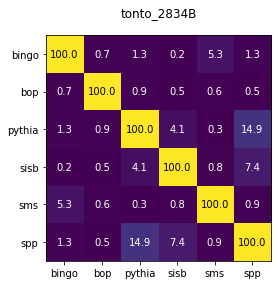

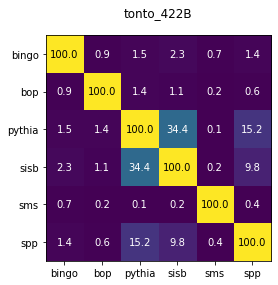

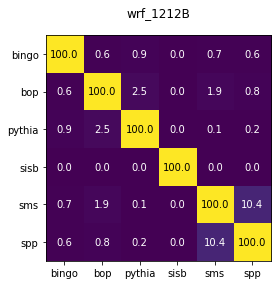

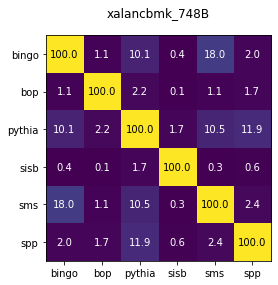

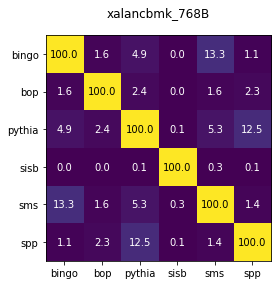

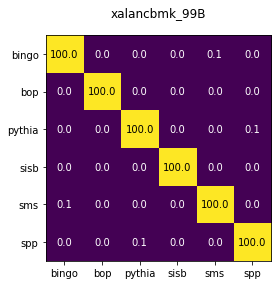

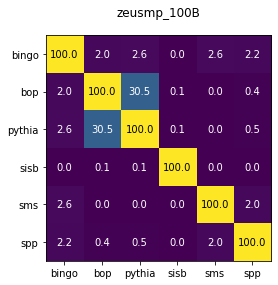

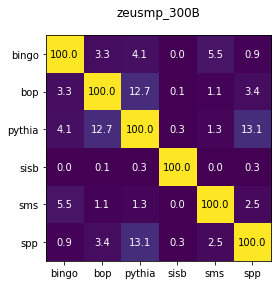

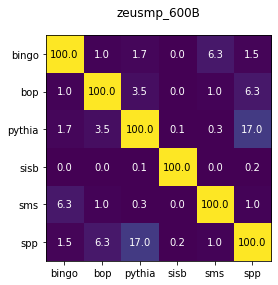

In [21]:
for trace in matrices:
    for simpoint in matrices[trace]:
        plot_overlap_matrix(matrices[trace][simpoint], labels, 
                            dpi=dpi, title=trace + '_' + simpoint)
        plt.savefig(f'plots/overlap/per_simpoint/{trace + "_" + simpoint}.pdf')
        plt.show()